
**<span style="font-size:20px">INSTALL SOME USEFUL LIBRARIES</span>**


In [3]:
pip install opencv-python pillow numpy scikit-learn tensorflow torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr


 **<span style="font-size:20px">LOAD IMAGES AND PREPROCESSING</span>**

In [5]:
def load_images_from_folder(folder, img_size=(128,128)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, img_size)  # Resize image
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
    return images


In [6]:
noisy_folder_path = 'C:/Users/HP/Downloads/low'
clean_folder_path = 'C:/Users/HP/Downloads/high'
img_size = (128, 128)  # Desired image size

noisy_images = load_images_from_folder(noisy_folder_path, img_size)
clean_images = load_images_from_folder(clean_folder_path, img_size)


 **<span style="font-size:20px">SPLIT DATASET INTO TRAINING AND TESTING</span>**

In [7]:
train_noisy, test_noisy, train_clean, test_clean = train_test_split(
    noisy_images, clean_images, test_size=0.2, random_state=42
)


In [8]:
def preprocess_image(image):
    return tf.image.convert_image_dtype(image, tf.float32)

# Create TensorFlow datasets
train_noisy_ds = tf.data.Dataset.from_tensor_slices(train_noisy).map(preprocess_image).batch(32)
train_clean_ds = tf.data.Dataset.from_tensor_slices(train_clean).map(preprocess_image).batch(32)
test_noisy_ds = tf.data.Dataset.from_tensor_slices(test_noisy).map(preprocess_image).batch(32)
test_clean_ds = tf.data.Dataset.from_tensor_slices(test_clean).map(preprocess_image).batch(32)

# Combine noisy and clean images for training
train_ds = tf.data.Dataset.zip((train_noisy_ds, train_clean_ds))
test_ds = tf.data.Dataset.zip((test_noisy_ds, test_clean_ds))


**<span style="font-size:20px">DEFINE THE PSNR FUNCTION AND CUSTOM PSNR CALLBACK</span>**

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, Sequential
from tensorflow.keras.layers import LeakyReLU

# Define the PSNR function
def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

# Define the custom PSNR callback
class PSNRCallback(callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_data = self.validation_data
        val_pred = self.model.predict(val_data[0])
        logs['val_psnr'] = psnr(val_data[1], val_pred).numpy().mean()
        print(f"Epoch {epoch + 1}: val_psnr = {logs['val_psnr']}")

 **<span style="font-size:20px">MODEL ARCHITECTURE</span>**

In [26]:
def create_denoising_model(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation=LeakyReLU(), padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation=LeakyReLU(), padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation=LeakyReLU(), padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation=LeakyReLU(), padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    return model

input_shape = (128, 128, 3)
model = create_denoising_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[psnr])
model.summary()

# Assuming you have training and validation datasets: train_ds and test_ds
val_data = next(iter(test_ds))  # Extract a batch from the validation dataset

# Instantiate the custom PSNR callback with validation data
psnr_callback = PSNRCallback(validation_data=val_data)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,731 (194.26 KB)

 Trainable params: 49,731 (194.26 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Assuming you have training and validation datasets: train_ds and test_ds
history = model.fit(train_ds, epochs=100, validation_data=test_ds, callbacks=[psnr_callback])

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/stepep - loss: 0.6893 - psnr: 13.75
Epoch 1: val_psnr = 15.58995246887207
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 0.6888 - psnr: 13.7779 - val_loss: 0.6645 - val_psnr: 15.5900
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/stepep - loss: 0.6674 - psnr: 15.41
Epoch 2: val_psnr = 15.238870620727539
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 589ms/step - loss: 0.6672 - psnr: 15.4185 - val_loss: 0.6580 - val_psnr: 15.2389
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/stepep - loss: 0.6607 - psnr: 15.50
Epoch 3: val_psnr = 15.86562728881836
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 559ms/step - loss: 0.6604 - psnr: 15.5164 - val_loss: 0.6509 - val_psnr: 15.8656
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/stepep - loss: 0.6539 - psnr: 15.99
Epoch 4: val_psnr = 16.35363006591797
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 555ms/step - loss: 0.6537 - psnr: 16.0106 - val_loss: 0.6488 - val_psnr: 16.3536
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/stepep - loss: 0.6532 - psnr: 1

**<span style="font-size:20px">PLOT FOR TRAINING AND TESTING LOSS WITH EPOCH</span>**

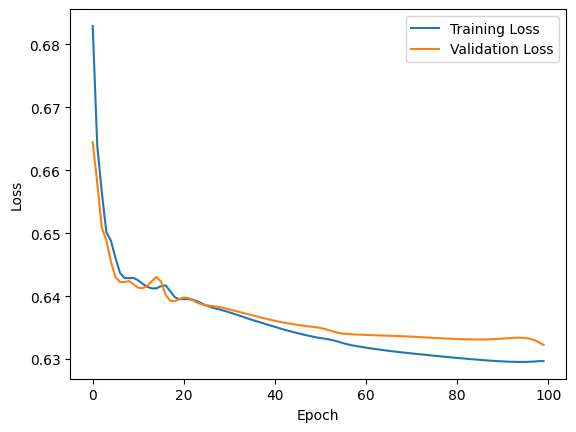

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

 **<span style="font-size:20px">CALCULATING PSNR SCORE FOR TESTING DATA</span>**

In [30]:
predicted_images = model.predict(test_noisy_ds)


psnr_values = [psnr(test_clean[i], predicted_images[i]) for i in range(len(test_clean))]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step
Average PSNR: 17.624347686767578


In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images from the given array
def display_images(images, num_images_to_display=5):
    # Determine how many images to display
    num_images = min(num_images_to_display, images.shape[0])
    
    # Create a figure to display the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    
    for i in range(num_images):
        ax = axes[i] if num_images > 1 else axes
        ax.imshow(images[i])
        ax.axis('off')
    
    plt.show()

# Assuming predicted_images is already defined and is a 4D NumPy array
# Example: predicted_images = np.random.rand(10, 64, 64, 3) # Just for demonstration



**<span style="font-size:20px">PREDICTED IMAGES</span>**

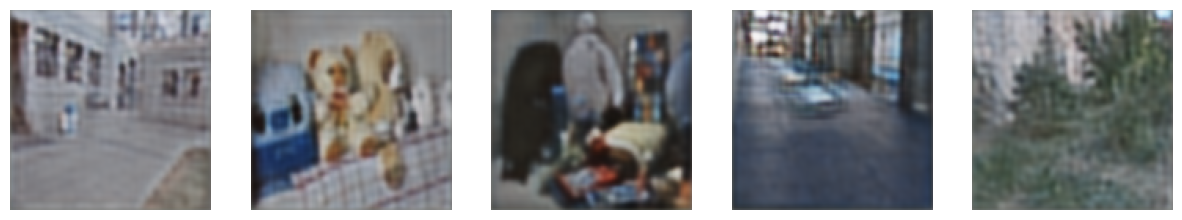

In [52]:
display_images(predicted_images)

**<span style="font-size:20px">NOISY IMAGES</span>**

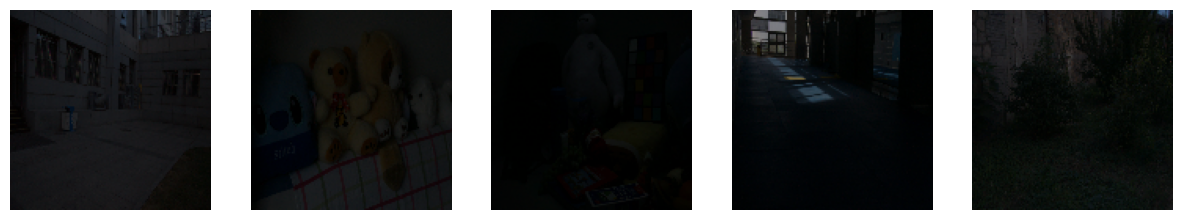

In [38]:
noisy_images = np.array(test_noisy)
display_images(noisy_images)

**<span style="font-size:20px">CLEAN IMAGES</span>**

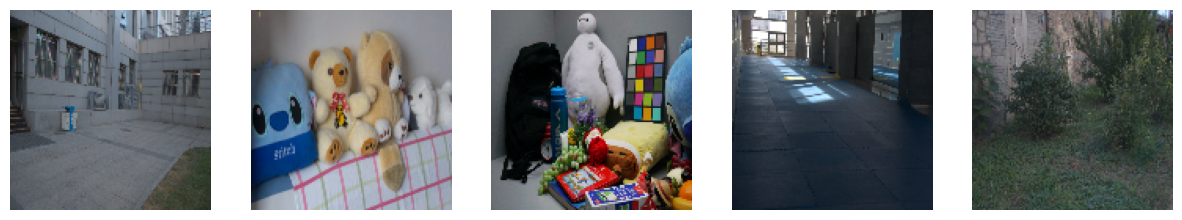

In [40]:
clean_images = np.array(test_clean)
display_images(clean_images)